In [2]:
import numpy as np
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords #불용어 : 중요한 의미를 가지지 않은 단어 (관사, 전치사)
from nltk.stem.porter import PorterStemmer #유사한 의미를 가진 단어들을 동일한 형태로 처리
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score #정확도 측정
from sklearn.metrics import confusion_matrix #혼동 행렬
from sklearn.metrics import classification_report

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yeong-
[nltk_data]     gwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
print(stopwords.words('english')) #영어의 불용어를 출력

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
news_data=pd.read_csv('train.csv') 
news_data.head()
#train_csv변수 : id, title, author, text, label

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
news_data.shape

(20800, 5)

In [11]:
news_data.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [13]:
news_data=news_data.fillna('') #널값에 공백 값을 채우기

In [14]:
news_data.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [15]:
news_data['content']=news_data['author']+' '+news_data['title'] 

In [16]:
print(news_data['content']) #저자와 제목을 합쳐 content 변수에 집어 넣음

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [17]:
X=news_data.drop(columns='label',axis=1) #label 열을 삭제함(axis1은 행을 삭제하는 것임)
Y=news_data['label'] #종속변수는 label로 설정 

In [18]:
Y.value_counts() 

1    10413
0    10387
Name: label, dtype: int64

In [19]:
X.shape

(20800, 5)

In [20]:
Y.shape

(20800,)

In [21]:
print(X) #독립변수 값 출력

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [22]:
print(Y) #종속변수 값 출력

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64


**STEMMING**<br>
언어를 정규화 시키는 알고리즘 - 유사하지만 다양한 형태의 단어를 공통된 형태로 줄일 수 있음<br>
actor, actress, acting --> act<br>
eating, eats, eaten --> eat

In [23]:
port_stem=PorterStemmer() #유사한 의미를 가진 단어들을 동일한 형태로 처리

In [27]:
def stemming(content): 
    review=re.sub('[^a-zA-Z]',' ',content)  #^는 반전을 의미 : a~z, A~Z를 제외한 것은 공백처리
    review=review.lower() #소문자로 변환하기
    review=review.split() #공백을 기준으로 스플릿
    review=[port_stem.stem(word) for word in review 
            if not word in stopwords.words('english')] #불용어 아니면 어간 추출 진행 
    review=' '.join(review) #단어들이 연결되게 함 ->
    #['word1', 'word2', 'word3'] => Resulting string will be 'word1 word2 word3'

    return review

#stem 어간추출 - the going → the go    https://wikidocs.net/21707


In [26]:
news_data['content']=news_data['content'].apply(stemming)
print(news_data['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [28]:
# [before]
# 0        darrel lucu hous dem aid even see comey letter...
# 1        daniel j flynn flynn hillari clinton big woman...
# 2                   consortiumnew com truth might get fire
# 3        jessica purkiss civilian kill singl us airstri...
# 4        howard portnoy iranian woman jail fiction unpu...
#                                ...                        
# 20795    jerom hudson rapper trump poster child white s...
# 20796    benjamin hoffman n f l playoff schedul matchup...
# 20797    michael j de la merc rachel abram maci said re...
# 20798    alex ansari nato russia hold parallel exercis ...
# 20799                            david swanson keep f aliv

# [after]
# 0        Darrell Lucus House Dem Aide: We Didn’t Even S...
# 1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
# 2        Consortiumnews.com Why the Truth Might Get You...
# 3        Jessica Purkiss 15 Civilians Killed In Single ...
# 4        Howard Portnoy Iranian woman jailed for fictio...
#                                ...                        
# 20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
# 20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
# 20797    Michael J. de la Merced and Rachel Abrams Macy..

In [30]:
X=news_data['content'].values
Y=news_data['label'].values

In [33]:
print(X)
print('\n')
print(Y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


[1 0 1 ... 0 1 1]


In [35]:
Y.shape 

(20800,)

In [39]:
vectorizer=TfidfVectorizer()  #TF-IDF : 단어의 중요도를 측정하는 수적 통걔 모델 기법
vectorizer.fit(X) #모델 학습
X=vectorizer.transform(X)

In [40]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.4154496266472162
  (2, 9620)	0.4935149294364995
  (2, 5968)	0.34746133867282925
  (2, 5389)	0.38665305511826153
  (2, 3103)	0.4609748958322965
  :	:
  (20797, 13122)	0.24825263521976057
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396505
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.17455348025522197
  (20797, 9518)	0.2954

In [41]:
#train, test 데이터세트 분할
X_train, X_test, Y_train,Y_test=train_test_split(X,Y, test_size=0.2,
                                                stratify=Y,
                                                random_state=2)

In [42]:
model=LogisticRegression()

In [43]:
model.fit(X_train,Y_train) #train 세트를 학습시킴

LogisticRegression()

In [46]:
X_train_prediction=model.predict(X_train) #X_trai의 예측 값 
training_data_accuracy=accuracy_score(X_train_prediction, Y_train)
training_data_accuracy

0.9865985576923076

In [92]:
X_test_prediction=model.predict(X_test)
test_data_accuracy=accuracy_score(X_test_prediction,Y_test)
print(test_data_accuracy)

0.9790865384615385


In [93]:
#CONFUSION MATRIX - 예측 라벨과 실제 라벨을 비교하는 것
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, #cm :시각화될 혼동 행렬/classes : 혼동행렬 라벨 이름
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar() #색깔 막대 바 넣기
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix") #정규화된 혼동행렬
    else:
        print('Confusion matrix, without normalization') #정규화 안된 혼동행렬
    thresh=cm.max() /2. #임계점 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [94]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.33, random_state=42)


In [95]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy: 0.950
Confusion matrix, without normalization


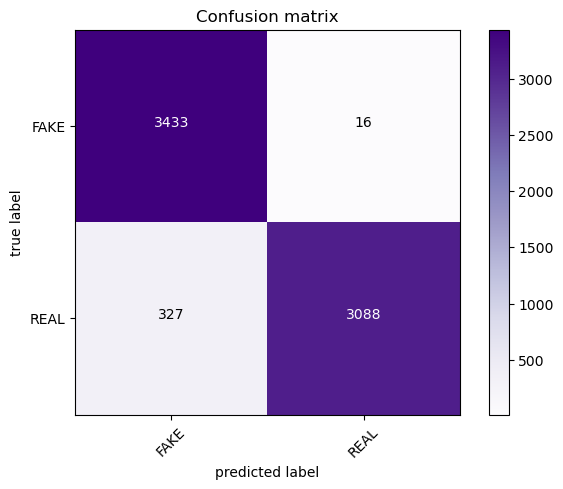

In [96]:
#CLASSIFICATION MODEL : MULTINOMIAL NAIVE BAYES
from sklearn import metrics
import itertools

classifier.fit(X1_train,Y1_train) #x1,y1 트레인 데이터를 학습 
prediction1=classifier.predict(X1_test)
score=metrics.accuracy_score(Y1_test, prediction1) #정확도 측정
print('accuracy: %0.3f' % score)
cm1=metrics.confusion_matrix(Y1_test, prediction1) 
plot_confusion_matrix(cm1,classes=['FAKE','REAL'])


In [97]:
#CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y, test_size=0.33,
                                                        random_state=42)

accuracy: 0.990
Confusion matrix, without normalization


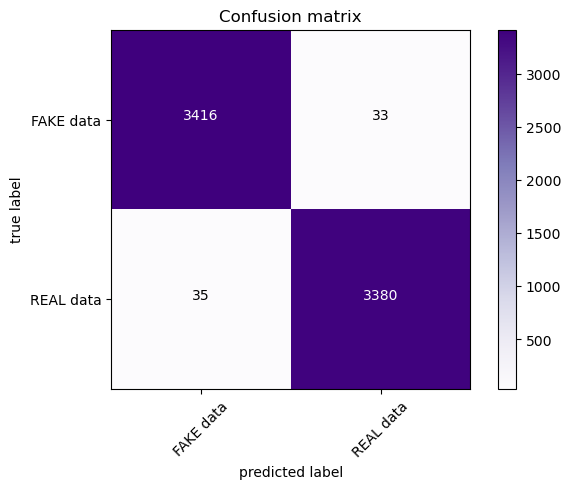

In [98]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf=PassiveAggressiveClassifier(max_iter=50)

linear_clf.fit(X2_train, Y2_train)
prediction2=linear_clf.predict(X2_test)
score=metrics.accuracy_score(Y2_test, prediction2) 
print('accuracy: %0.3f' % score)
cm2=metrics.confusion_matrix(Y2_test, prediction2)
plot_confusion_matrix(cm2,classes=['FAKE data','REAL data'])


In [99]:
X_new=X_test[0]
prediction=model.predict(X_new)
print(prediction)

if (prediction[0]==0):
    print('The news is Real')
else: 
    print('The news is Fake')

[1]
The news is Fake


In [100]:
print(Y_test[0])

1


In [101]:
X1_new=X1_test[0]
prediction=model.predict(X1_new)
print(prediction)

if (prediction[0]==0):
    print('The news is Real')
else: 
    print('The news is Fake')

[1]
The news is Fake


In [102]:
print(Y1_test[0])

1


In [103]:
X2_new=X2_test[0]

prediction=model.predict(X2_new)
print(prediction)

if (prediction[0]==0):
    print('The news is Real')
else: 
    print('The news is Fake')


[1]
The news is Fake


In [104]:
print(Y2_test[0])

1


In [105]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



In [106]:
from sklearn.metrics import classification_report
print(classification_report(Y1_test,prediction1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3449
           1       0.99      0.90      0.95      3415

    accuracy                           0.95      6864
   macro avg       0.95      0.95      0.95      6864
weighted avg       0.95      0.95      0.95      6864



In [107]:
from sklearn.metrics import classification_report
print(classification_report(Y2_test,prediction2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.99      0.99      0.99      3415

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864

